In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, from_unixtime, to_date

# Tạo SparkSession

spark = SparkSession.builder \
    .appName("Sales Revenue Forecasting") \
    .master("local[*]") \
    .config("spark.driver.memory", "8g") \
    .getOrCreate()


# Đọc dữ liệu từ nhiều file Parquet
df_meta = spark.read.parquet(r"file:///C:\Users\PC\OneDrive\Dokumen\Amazon_sales_forecasting\data\metadata\meta_Clothing_Shoes_and_Jewelry_*.parquet")
df_reviews = spark.read.json("D:\Clothing_Shoes_and_Jewelry\Clothing_Shoes_and_Jewelry.jsonl")

In [2]:
cols_needed = [
    "parent_asin", "title", "price", "average_rating", "rating_number",
    "categories", "features", "description",
    "main_category", "store"
]


df_meta_filtered = df_meta.select([col for col in cols_needed if col in df_meta.columns])
# df_filtered.printSchema()
df_meta_filtered.show(8, truncate=100)

+-----------+----------------------------------------------------------------------------------------------------+------+--------------+-------------+---------------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------+--------------+------------------+
|parent_asin|                                                                                               title| price|average_rating|rating_number|                                                                                         categories|                                                                                            features|                                                                                         description| main_category|             store|
+-----------+-------------

In [3]:
reviews = df_reviews.withColumn("date", to_date(from_unixtime(col("timestamp") / 1000)))

joined_df = reviews.join(
    df_meta_filtered, 
    on="parent_asin", 
    how="left"
)

joined_df.printSchema()

root
 |-- parent_asin: string (nullable = true)
 |-- asin: string (nullable = true)
 |-- helpful_vote: long (nullable = true)
 |-- images: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- attachment_type: string (nullable = true)
 |    |    |-- large_image_url: string (nullable = true)
 |    |    |-- medium_image_url: string (nullable = true)
 |    |    |-- small_image_url: string (nullable = true)
 |-- rating: double (nullable = true)
 |-- text: string (nullable = true)
 |-- timestamp: long (nullable = true)
 |-- title: string (nullable = true)
 |-- user_id: string (nullable = true)
 |-- verified_purchase: boolean (nullable = true)
 |-- date: date (nullable = true)
 |-- title: string (nullable = true)
 |-- price: double (nullable = true)
 |-- average_rating: double (nullable = true)
 |-- rating_number: long (nullable = true)
 |-- categories: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- features: array (nullable = tr

In [4]:
from pyspark.sql.functions import col, to_date, sum as _sum, count, avg

# Bước 1: Tính doanh thu theo ngày cho từng sản phẩm (parent_asin)
revenue_df = joined_df.filter(col("price").isNotNull()) \
    .withColumn("date", to_date("date")) \
    .groupBy("parent_asin", "date") \
    .agg(
        _sum("price").alias("daily_revenue"),
        count("*").alias("num_reviews")
    )

In [5]:
# Bước 2: Tính tổng doanh thu và số ngày có dữ liệu cho mỗi sản phẩm
asin_metrics = revenue_df.groupBy("parent_asin") \
    .agg(
        count("*").alias("num_days"),
        _sum("daily_revenue").alias("total_revenue"),
        avg("daily_revenue").alias("avg_daily_revenue")
    ) \
    .filter(col("num_days") > 30) \
    .orderBy(col("total_revenue").desc())

In [6]:
# Bước 3: Lấy parent_asin có doanh thu cao nhất
# Dùng .take() để tránh crash
top_asin_row = asin_metrics.take(1)[0]  # nhẹ hơn .collect()
asin_id = top_asin_row["parent_asin"]

In [7]:
print(f"Top parent_asin được chọn: {asin_id}")

Top parent_asin được chọn: B07TVHSDMQ


In [8]:
# Bước 4: Lấy dữ liệu doanh thu theo ngày của sản phẩm đó
target_df = revenue_df.filter(col("parent_asin") == asin_id) \
    .orderBy("date")

In [9]:
# Bước 5: Chuyển sang Pandas để dự báo
df_pd = target_df.select("date", "daily_revenue").toPandas()
df_pd.head()

,date,daily_revenue
0,2017-11-29,17.99
1,2017-12-01,17.99
2,2017-12-09,17.99
3,2017-12-15,35.98
4,2017-12-16,35.98


In [10]:
print(df_pd.shape)

(2095, 2)


In [11]:
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler

# 1. Chuẩn hóa dữ liệu
scaler = MinMaxScaler()
sales_scaled = scaler.fit_transform(df_pd["daily_revenue"].values.reshape(-1, 1))

# 2. Tạo chuỗi đầu vào cho LSTM
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:i+seq_length]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

SEQ_LENGTH = 14  # sử dụng 14 ngày gần nhất để dự báo ngày tiếp theo
X, y = create_sequences(sales_scaled, SEQ_LENGTH)

# 3. Chuyển sang tensor
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32)


In [12]:
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, num_layers=2):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        out, _ = self.lstm(x, (h0, c0))  # [batch_size, seq_length, hidden_size]
        out = self.fc(out[:, -1, :])     # Lấy output tại thời điểm cuối cùng
        return out


In [13]:
model = LSTMModel()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

EPOCHS = 200
for epoch in range(EPOCHS):
    model.train()
    output = model(X_tensor)
    loss = criterion(output, y_tensor)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch+1) % 10 == 0:
        print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {loss.item():.6f}")


Epoch 10/200, Loss: 0.024476
Epoch 20/200, Loss: 0.014862
Epoch 30/200, Loss: 0.006975
Epoch 40/200, Loss: 0.005657
Epoch 50/200, Loss: 0.005475
Epoch 60/200, Loss: 0.005131
Epoch 70/200, Loss: 0.005030
Epoch 80/200, Loss: 0.004935
Epoch 90/200, Loss: 0.004842
Epoch 100/200, Loss: 0.004746
Epoch 110/200, Loss: 0.004635
Epoch 120/200, Loss: 0.004500
Epoch 130/200, Loss: 0.004333
Epoch 140/200, Loss: 0.004145
Epoch 150/200, Loss: 0.004014
Epoch 160/200, Loss: 0.003941
Epoch 170/200, Loss: 0.004066
Epoch 180/200, Loss: 0.003883
Epoch 190/200, Loss: 0.003867
Epoch 200/200, Loss: 0.003836


In [14]:
# Lấy chuỗi 14 ngày cuối để dự báo
last_seq = sales_scaled[-SEQ_LENGTH:]
last_seq = torch.tensor(last_seq.reshape(1, SEQ_LENGTH, 1), dtype=torch.float32)

model.eval()
with torch.no_grad():
    pred = model(last_seq).item()

# Chuyển về giá trị gốc
predicted_count = scaler.inverse_transform([[pred]])[0][0]
print(f"Dự báo doanh số cho ngày tiếp theo: {predicted_count:.2f}")


Dự báo doanh số cho ngày tiếp theo: 64.40


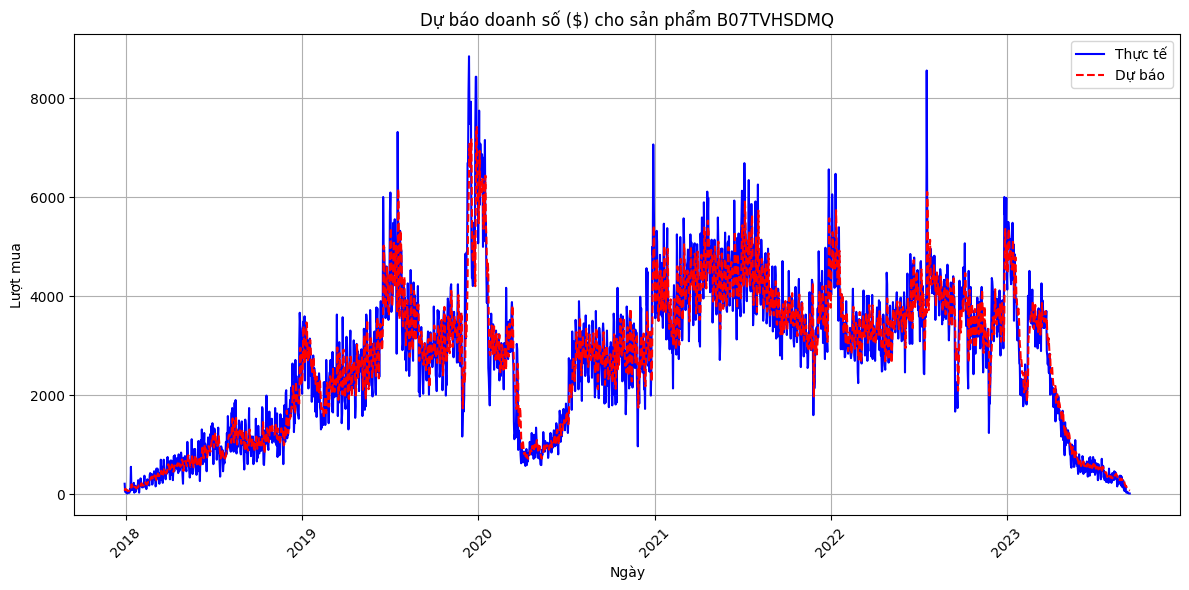

In [15]:
import matplotlib.pyplot as plt

# Dự báo toàn bộ chuỗi để so sánh (one-step ahead forecast)
model.eval()
with torch.no_grad():
    predicted_all = model(X_tensor).squeeze().numpy()

# Chuyển về giá trị gốc
predicted_all = scaler.inverse_transform(predicted_all.reshape(-1, 1)).flatten()
actual_all = scaler.inverse_transform(y_tensor.numpy().reshape(-1, 1)).flatten()

# Tạo mảng ngày tương ứng (từ ngày thứ SEQ_LENGTH trở đi)
dates = df_pd['date'].values[SEQ_LENGTH:]

# Vẽ biểu đồ
plt.figure(figsize=(12, 6))
plt.plot(dates, actual_all, label='Thực tế', color='blue')
plt.plot(dates, predicted_all, label='Dự báo', color='red', linestyle='--')
plt.xticks(rotation=45)
plt.title(f"Dự báo doanh số ($) cho sản phẩm {asin_id}")
plt.xlabel("Ngày")
plt.ylabel("Lượt mua")
plt.legend()
plt.tight_layout()
plt.grid(True)
plt.show()
